# Практическое задание 

## Урок 2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import warnings
warnings.filterwarnings("ignore")

### Подготовим код

In [2]:
import pandas as pd

In [3]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [4]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [5]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [6]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [ ]:
import nltk
nltk.download('stopwords')

stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: total: 30.5 s
Wall time: 30.6 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: total: 3min 47s
Wall time: 3min 48s


In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [13]:
common_dictionary[10]

'ватутин'

In [14]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: total: 1min 54s
Wall time: 43.1 s


In [15]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [16]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(11, 0.34389436),
 (12, 0.38577506),
 (15, 0.09946244),
 (20, 0.041145924),
 (22, 0.11190395)]

In [17]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: век парк золото медик осложнение уральский золотой
topic_1: погибнуть рак миссия товар высота испытание теория
topic_2: германия европа греция италия подсчитать порт ск
topic_3: ребёнок человек гражданин это который выяснить район
topic_4: больной профсоюз мешок джеймс миллер скворцов впечатляющий
topic_5: страдать собирать коллекция альянс си сингапур ка
topic_6: млн год составить университет фотография банк доля
topic_7: египетский показ китаец предприниматель мак триумф кортес
topic_8: операция врач расследование который министерство это год
topic_9: человек фонд территория тыс город пенсия помощь
topic_10: участок торговый вирус погибнуть балтийский арбитраж комплекс
topic_11: взрыв дональд энергия проверять дневный катастрофа инвестировать
topic_12: это год система исследование мочь новый проект
topic_13: белоруссия общество уголовный год подчёркивать преступление лицо
topic_14: ракета военный км боевой космонавт пилот техника
topic_15: год который это nn рубль статья суд

In [18]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [19]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.900988,0.0,0.000000,0.000000,0.0,0.012849,0.000000,0.0
1,4896,0.0,0.0,0.032067,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.145922,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,4897,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.098995,0.000000,0.000000,0.0,0.000000,0.041106,0.0,0.113309,0.000000,0.0
3,4898,0.0,0.0,0.000000,0.0,0.0,0.0,0.018302,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.447126,0.045273,0.0
4,4899,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.032855,0.417573,0.0,0.294127,0.000000,0.0,0.000000,0.124993,0.0


### Следующий шаг - векторные представления пользователей

In [20]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [22]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.07475308, 0.        ,
       0.        , 0.        , 0.        , 0.12980346, 0.        ,
       0.0167411 , 0.        , 0.01568651, 0.0740155 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.24282697,
       0.02238119, 0.        , 0.41343603, 0.        , 0.        ])

In [23]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [24]:
get_user_embedding(user_articles_list)

array([0.        , 0.01345972, 0.        , 0.0152811 , 0.00566136,
       0.00865461, 0.        , 0.        , 0.01231434, 0.01778765,
       0.        , 0.00186572, 0.03666212, 0.04836526, 0.02149228,
       0.16559593, 0.        , 0.18458595, 0.        , 0.15326293,
       0.        , 0.0208712 , 0.06278022, 0.20869413, 0.01188987])

In [25]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.003244,0.000000,0.072190,0.000000,0.000000,0.002527,0.0,0.065845,...,0.045792,0.007233,0.297433,0.000000,0.080474,0.003730,0.070116,0.150029,0.040183,0.000000
1,u108690,0.0,0.000000,0.004104,0.025322,0.004026,0.000000,0.006491,0.0,0.046372,...,0.062606,0.000000,0.225205,0.010526,0.104779,0.005562,0.043846,0.129017,0.180160,0.039549
2,u108339,0.0,0.016422,0.002880,0.075992,0.000000,0.009167,0.009737,0.0,0.087190,...,0.100238,0.007716,0.236789,0.002335,0.108595,0.000000,0.055107,0.059834,0.050403,0.014790


In [26]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [27]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.003244,0.000000,0.072190,0.000000,0.000000,0.002527,0.0,0.065845,...,0.007233,0.297433,0.000000,0.080474,0.003730,0.070116,0.150029,0.040183,0.000000,0
1,u108690,0.0,0.000000,0.004104,0.025322,0.004026,0.000000,0.006491,0.0,0.046372,...,0.000000,0.225205,0.010526,0.104779,0.005562,0.043846,0.129017,0.180160,0.039549,1
2,u108339,0.0,0.016422,0.002880,0.075992,0.000000,0.009167,0.009737,0.0,0.087190,...,0.007716,0.236789,0.002335,0.108595,0.000000,0.055107,0.059834,0.050403,0.014790,1


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [30]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [31]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.12783766, 0.04350857, 0.28896167, 0.19575708, 0.05219993,
       0.12680005, 0.26356028, 0.06987833, 0.19607115, 0.14938955])

In [32]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.229550, F-Score=0.644, Precision=0.595, Recall=0.702


In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1638  117]
 [  74  171]]


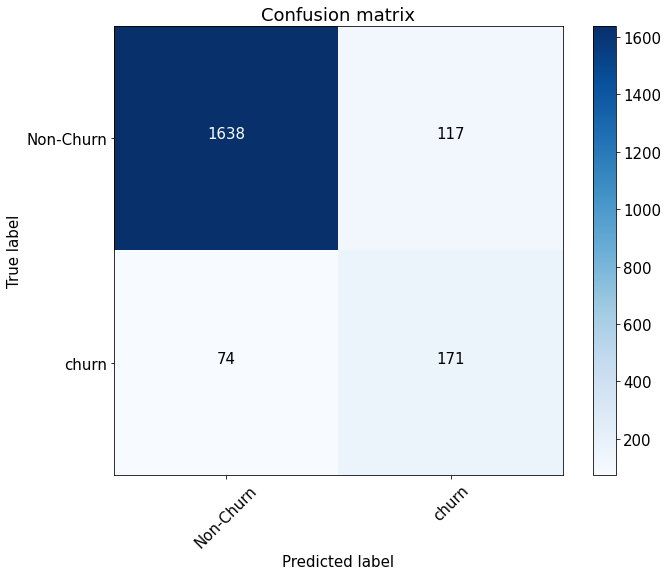

In [35]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [36]:
roc_auc_sc = roc_auc_score(y_test, preds)
roc_auc_sc

0.9295726495726496

$$ *** $$

# Решение домашнего задания

In [37]:
# определим списки в который будем помещать данные разных методов получения эмбедингов пользователей: 
# mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

list_headlines = ['roc_auc', 'precision', 'recall', 'f_score']
list_index = ['mean', 'median', 'max']

list_metrix_mean = [] 
list_metrix_median = [] 
list_metrix_max = [] 
list_metrix_idf_mean = [] 

In [38]:
# добавим данные получения эмбедингов с помощью mean (который рассматривался на уроке)

list_metrix_mean.append(roc_auc_sc)
list_metrix_mean.append(precision[ix])
list_metrix_mean.append(recall[ix])
list_metrix_mean.append(fscore[ix])

print(list_metrix_mean)

[0.9295726495726496, 0.5951557093425606, 0.7020408163265306, 0.6441947565543071]


1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

In [39]:
# самостоятельно проработал информацию по указанным ссылкам

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [40]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [41]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.07561266, 0.        , 0.14529518, 0.        , 0.15560633,
       0.        , 0.        , 0.01523185, 0.18269666, 0.        ])

In [42]:
user_embeddings_medians= pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_medians.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_medians['uid'] = users['uid'].values
user_embeddings_medians = user_embeddings_medians[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_medians.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.0,0.037377,0.0,0.0,0.0,0.0,0.072253,...,0.000000,0.0,0.295431,0.000000,0.062451,0.0,0.039585,0.134711,0.000000,0.0
1,u108690,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.056830,...,0.049769,0.0,0.195122,0.009763,0.110398,0.0,0.042961,0.067794,0.204043,0.0
2,u108339,0.0,0.008062,0.0,0.050941,0.0,0.0,0.0,0.0,0.099620,...,0.093754,0.0,0.234478,0.000000,0.094765,0.0,0.031075,0.050471,0.011513,0.0


In [43]:
target_median = pd.read_csv("users_churn.csv")
target_median.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [44]:
X_median = pd.merge(user_embeddings_medians, target_median, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.0,0.037377,0.0,0.0,0.0,0.0,0.072253,...,0.0,0.295431,0.000000,0.062451,0.0,0.039585,0.134711,0.000000,0.0,0
1,u108690,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.056830,...,0.0,0.195122,0.009763,0.110398,0.0,0.042961,0.067794,0.204043,0.0,1
2,u108339,0.0,0.008062,0.0,0.050941,0.0,0.0,0.0,0.0,0.099620,...,0.0,0.234478,0.000000,0.094765,0.0,0.031075,0.050471,0.011513,0.0,1


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [46]:
#разделим данные на train/test
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                   X_median['churn'], random_state=0)

In [47]:
logreg_median = LogisticRegression()
#обучим 
logreg_median.fit(X_train_median, y_train_median)

LogisticRegression()

In [48]:
#наши прогнозы для тестовой выборки
preds_median = logreg.predict_proba(X_test_median)[:, 1]
preds_median[:10]

array([0.09613533, 0.0206201 , 0.22548499, 0.17256982, 0.05075828,
       0.0556884 , 0.16720161, 0.02922598, 0.1717505 , 0.1000187 ])

In [49]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test_median, preds_median)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix_median = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_median], 
                                                                        fscore[ix_median],
                                                                        precision[ix_median],
                                                                        recall[ix_median]))

Best Threshold=0.173217, F-Score=0.710, Precision=0.649, Recall=0.784


Confusion matrix, without normalization
[[1667   88]
 [  67  178]]


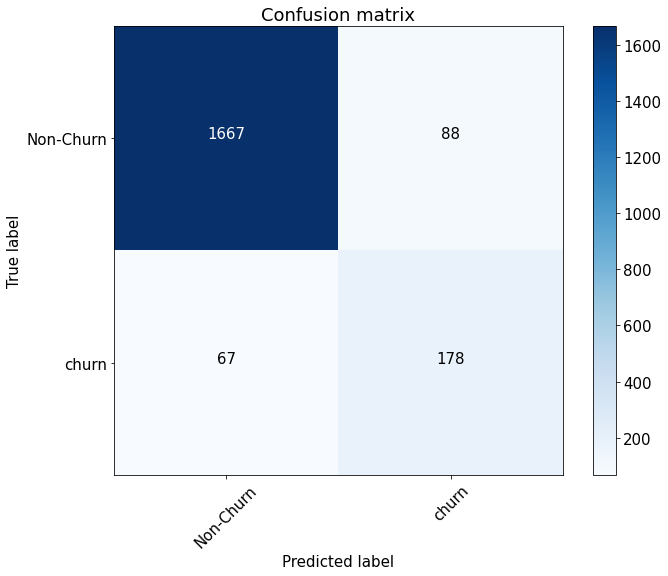

In [51]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_median, preds_median>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [52]:
roc_auc_sc_median = roc_auc_score(y_test_median, preds_median)
roc_auc_sc_median

0.9506064306064306

In [53]:
list_metrix_median.append(roc_auc_sc_median)
list_metrix_median.append(precision[ix_median])
list_metrix_median.append(recall[ix_median])
list_metrix_median.append(fscore[ix_median])

In [54]:
print(list_metrix_mean)

[0.9295726495726496, 0.5951557093425606, 0.7020408163265306, 0.6441947565543071]


In [55]:
print(list_metrix_median)

[0.9506064306064306, 0.6486486486486487, 0.7836734693877551, 0.709796672828096]


3. Повторить п.2, но используя уже не медиану, а max

In [56]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [57]:
get_user_embedding_max(user_articles_list)

array([0.        , 0.08075832, 0.        , 0.07327823, 0.03396814,
       0.05192766, 0.        , 0.        , 0.07388604, 0.06366704,
       0.        , 0.01119433, 0.21997273, 0.26047975, 0.07012821,
       0.47421572, 0.        , 0.44598976, 0.        , 0.30932283,
       0.        , 0.09573687, 0.24939702, 0.6308859 , 0.04281186])

In [58]:
user_embeddings_maxs= pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_maxs.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_maxs['uid'] = users['uid'].values
user_embeddings_maxs = user_embeddings_maxs[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_maxs.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.019466,0.000000,0.277377,0.000000,0.000,0.015162,0.0,0.129803,...,0.206517,0.043396,0.570484,0.00000,0.242827,0.022381,0.184013,0.413436,0.241100,0.000000
1,u108690,0.0,0.000000,0.024627,0.115474,0.024154,0.000,0.028449,0.0,0.068565,...,0.151408,0.000000,0.412398,0.02232,0.254451,0.033371,0.093040,0.404022,0.264035,0.187672
2,u108339,0.0,0.057191,0.017282,0.234125,0.000000,0.055,0.036278,0.0,0.139568,...,0.198088,0.029197,0.447329,0.01401,0.250983,0.000000,0.155474,0.142904,0.150450,0.078358


In [59]:
target_max = pd.read_csv("users_churn.csv")
target_max.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [60]:
X_max = pd.merge(user_embeddings_maxs, target_max, 'left')
X_max .head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.019466,0.000000,0.277377,0.000000,0.000,0.015162,0.0,0.129803,...,0.043396,0.570484,0.00000,0.242827,0.022381,0.184013,0.413436,0.241100,0.000000,0
1,u108690,0.0,0.000000,0.024627,0.115474,0.024154,0.000,0.028449,0.0,0.068565,...,0.000000,0.412398,0.02232,0.254451,0.033371,0.093040,0.404022,0.264035,0.187672,1
2,u108339,0.0,0.057191,0.017282,0.234125,0.000000,0.055,0.036278,0.0,0.139568,...,0.029197,0.447329,0.01401,0.250983,0.000000,0.155474,0.142904,0.150450,0.078358,1


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [62]:
#разделим данные на train/test
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

In [63]:
logreg_max = LogisticRegression()
#обучим 
logreg_max.fit(X_train_max, y_train_max)

LogisticRegression()

In [64]:
#наши прогнозы для тестовой выборки
preds_max = logreg_max.predict_proba(X_test_max)[:, 1]
preds_max[:10]

array([0.06356277, 0.00212262, 0.53695278, 0.35300783, 0.0719713 ,
       0.00152483, 0.22513933, 0.02812575, 0.05193201, 0.10811814])

In [65]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [66]:
precision, recall, thresholds = precision_recall_curve(y_test_max, preds_max)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix_max  = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_max], 
                                                                        fscore[ix_max],
                                                                        precision[ix_max],
                                                                        recall[ix_max]))

Best Threshold=0.356163, F-Score=0.738, Precision=0.787, Recall=0.694


Confusion matrix, without normalization
[[1713   42]
 [  82  163]]


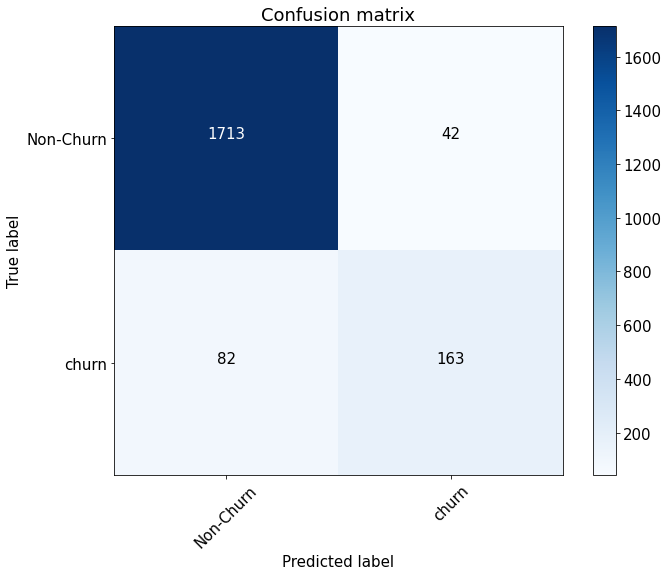

In [67]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_max, preds_max>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [68]:
roc_auc_sc_max = roc_auc_score(y_test_max, preds_max)
roc_auc_sc_max

0.9604163032734461

In [69]:
list_metrix_max.append(roc_auc_sc_max)
list_metrix_max.append(precision[ix_max])
list_metrix_max.append(recall[ix_max])
list_metrix_max.append(fscore[ix_max])

In [70]:
print(list_metrix_mean)

[0.9295726495726496, 0.5951557093425606, 0.7020408163265306, 0.6441947565543071]


In [71]:
print(list_metrix_median)

[0.9506064306064306, 0.6486486486486487, 0.7836734693877551, 0.709796672828096]


In [72]:
print(list_metrix_max)

[0.9604163032734461, 0.7870370370370371, 0.6938775510204082, 0.737527114967462]


In [73]:
list_pivot = []

list_pivot.append(list_metrix_mean)
list_pivot.append(list_metrix_median)
list_pivot.append(list_metrix_max)

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [74]:
metrics_pivot=pd.DataFrame(list_pivot, columns=list_headlines, index=list_index)
metrics_pivot.T

,mean,median,max
roc_auc,0.929573,0.950606,0.960416
precision,0.595156,0.648649,0.787037
recall,0.702041,0.783673,0.693878
f_score,0.644195,0.709797,0.737527


6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Вывод: Способ получения эмбедингов с помощью max (получение макимального вектора) оказался наиболее эффективным, так как был получен максимальный вектор заинтересованности пользователя, то есть статьи, которые пользователь читает наиболее часто.